In [4]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

from pprint import pprint
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train = np.loadtxt('training_set.txt', delimiter = ',', dtype = 'float32')
validation = np.loadtxt('validation_set.txt', delimiter = ',', dtype = 'float32')
test = np.loadtxt('test_set.txt', delimiter = ',', dtype = 'float32')

In [32]:
trainX, trainY = np.hsplit(train, [4])
trainY = trainY.flatten().astype(np.int32)

valX, valY = np.hsplit(test, [4])
valY = valY.flatten().astype(np.int32)

testX, testY = np.hsplit(test, [4])
testY = testY.flatten().astype(np.int32)

pprint(trainX.shape)
pprint(trainY.shape)
pprint(testX.shape)


(1827, 4)
(1827,)
(608, 4)


In [26]:
n_units = 100

class MLP(Chain):
    def __init__(self):
        super(MLP, self).__init__(
            l1 = F.Linear(4, n_units),
            l2 = F.Linear(n_units, n_units),
            l3 = F.Linear(n_units, n_units),
            l4 = F.Linear(n_units, 3)
        )
    
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        return self.l4(h3)

In [29]:
batchsize = 100
m = len(trainX)
epoches = range(100)
losses = []
accuracies = []

model = L.Classifier(MLP())
optimizer = optimizers.Adam()
optimizer.setup(model)

for epoch in epoches:
    if epoch % 10 == 0:
        print('epoch %d' % epoch)
        
    perm = np.random.permutation(m)
    sum_loss, sum_accuracy = 0, 0
    
    for i in range(0, m, batchsize):
        x = Variable(trainX[perm[i : i + batchsize]])
        t = Variable(trainY[perm[i : i + batchsize]])
        optimizer.update(model, x, t)
        
        sum_loss += float(model.loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)
        
    losses.append(sum_loss / m)
    accuracies.append(sum_accuracy / m)

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90


(0, 1)

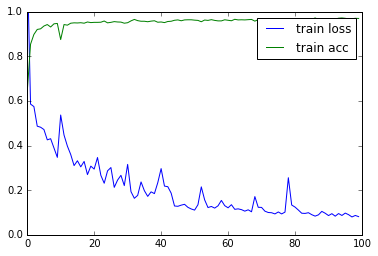

In [30]:
plt.plot(epoches, losses, label = "train loss")
plt.plot(epoches, accuracies, label = "train acc")
plt.legend()
plt.ylim(0, 1)

In [55]:
m = len(testX)
sum_loss, sum_accuracy = 0, 0

for i in range(0, len(testX), batchsize):
    x = Variable(testX[i : i + batchsize])
    t = Variable(testY[i : i + batchsize])
    loss = model(x, t)
    
    sum_loss += float(loss.data) * len(t.data)
    sum_accuracy += float(model.accuracy.data) * len(t.data)

pprint(sum_loss / m)
pprint(sum_accuracy / m)

0.08413130650296807
0.9687500003921358


In [93]:
res = 0
for i in range(0, m):
    x = Variable(testX[i].reshape(1, 4))
    h = model.predictor(x).data.argmax()
    
    if h == testY[i]:
        res += 1
    else:
        pprint(x.data)
        print("h = %d, y = %d" % (h, testY[i]))

pprint(res / m)

array([[ 11.        ,  13.        ,   0.        ,   0.36074609]], dtype=float32)
h = 1, y = 0
array([[ 58.        ,  59.        ,   0.        ,   0.86816448]], dtype=float32)
h = 1, y = 0
array([[ 2.        ,  4.        ,  1.        ,  0.90334886]], dtype=float32)
h = 2, y = 0
array([[ 72.        ,  69.        ,   1.        ,   0.80584991]], dtype=float32)
h = 0, y = 2
array([[ 38.        ,   2.        ,   0.        ,   0.84781688]], dtype=float32)
h = 1, y = 0
array([[ 50.        ,   1.        ,   0.        ,   0.73887241]], dtype=float32)
h = 1, y = 0
array([[ 42.        ,  40.        ,   0.        ,   0.56379825]], dtype=float32)
h = 1, y = 0
array([[ 17.        ,  27.        ,   0.        ,   0.56337434]], dtype=float32)
h = 1, y = 0
array([[ 4.        ,  4.        ,  0.        ,  0.18016109]], dtype=float32)
h = 0, y = 1
array([[ 32.        ,   1.        ,   0.        ,   0.57015687]], dtype=float32)
h = 1, y = 0
array([[ 12.        ,  11.        ,   0.        ,   0.68927515]], dt